In [74]:
import os
import sys
import glob
import scipy
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.manifold
from collections import defaultdict
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline
sns.set_style('whitegrid')
pd.set_option('display.max_rows', 100)
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['pdf.fonttype'] = 42
pd.set_option('display.max_columns', 100)
import matplotlib.patches as mpatches

## Point to needed supplemental information

In [53]:
DATA_LOC = '/data8/Human/FungiPaper/Datasheets/MappingListGamma_genomeCoverage_v1.csv'

## Load and parse genome coverage information

In [54]:
Gdb = pd.read_csv(DATA_LOC)

In [55]:
Gdb['DOL'] = [int(x[7:10]) for x in Gdb['sample']]
Gdb['loc'] = [x[10] for x in Gdb['sample']]
Gdb['infant'] = [x[:6] for x in Gdb['sample']]

In [56]:
n2n = {'Candida albicans SC5314':'Candida albicans',\
       'C_parapsilosis_CDC317_current_chromosomes':'Candida parapsilosis',\
      'Clavispora lusitaniae ATCC 42720':'Clavispora lusitaniae',\
       'Candida tropicalis MYA-3404':'Candida tropicalis',\
      'Malassezia sympodialis ATCC 42132':'Malassezia sympodialis',\
      'Trichosporon asahii var. asahii CBS 2479':'Trichosporon asahii',\
      'Purpureocillium lilacinum': 'Purpureocillium lilacinum',\
      'Candida dubliniensis CD36': 'Candida dubliniensis',\
      'Malassezia pachydermatis': 'Malassezia pachydermatis'}
Gdb['common_name'] = Gdb['name'].map(n2n)

# Limits of detection

### Make sure there aren't any samples with high breadth and really low coverage

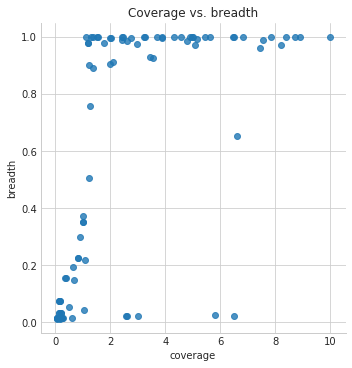

In [60]:
MIN = .01
MAX = 10

Fdb = Gdb[Gdb['genome'].isin(list(Gdb['genome'][Gdb['breadth'] >= .1].unique()))]
Fdb = Fdb[(Fdb['breadth'] >= MIN) & (Fdb['coverage'] <= MAX)]

sns.lmplot(data=Fdb, x='coverage', y='breadth', fit_reg=False)
plt.title("Coverage vs. breadth")
plt.show()

In [61]:
BREADTH = 0.1
print("Lowest coverage with {0} breadth is {1:.4f}".format(\
    BREADTH, Gdb['coverage'][Gdb['breadth'] >= BREADTH].min()))

Lowest coverage with 0.1 breadth is 0.3541


# Plot infant sparklines

### Set up dataframe for figure 

In [62]:
Bdb = Gdb.copy()

Bdb = Bdb[Bdb['loc'] == 'G']
relevent_genomes = Bdb['common_name'][(Bdb['breadth'] >= 0.1)].unique()
relevent_infants = Bdb['infant'][(Bdb['breadth'] >= 0.1)].unique()
Bdb = Bdb[(Bdb['common_name'].isin(relevent_genomes)) & \
          (Bdb['infant'].isin(relevent_infants))]

Bdb['DOL'] = [int(x[7:10]) + int(x[11])*0.5 if x[:6] == 'SP_CRL' \
              else d for x,d in zip(Bdb['sample'], Bdb['DOL'])]

### Set up colormap

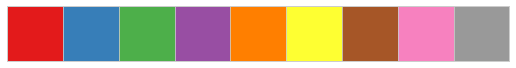

In [63]:
cp = sns.choose_colorbrewer_palette('qualitative')
assert len(cp) == len(relevent_genomes)
cm = {g:c for g,c in zip(relevent_genomes, cp)}
cm['Candida tropicalis'] = (189/360.,183/360.,107/360.)

### Set up order

In [64]:
order = ['Candida albicans', 'Purpureocillium lilacinum',
         'Candida dubliniensis', 'Candida parapsilosis',
       'Candida tropicalis', 'Clavispora lusitaniae', 
       'Malassezia pachydermatis', 'Malassezia sympodialis', 'Trichosporon asahii', 
       ]

i2m = defaultdict(int)
for gen, gdb in Bdb.groupby('common_name'):
    for inf, db in gdb.groupby('infant'):
        if len(db[db['breadth'] >= .1]) == 0:
            continue
        db = db[db['DOL'] != 0]
        i2m[inf] = max(db['relative_abundance'].max(), i2m[inf])

iorder = sorted(i2m, key=i2m.get, reverse=True)

### Plot

/home/mattolm/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Candida albicans N1_023 96.25
Candida albicans N5_264 78.41
Candida albicans S2_006 13.14
Candida albicans N2_070 5.13
Candida albicans SP_CRL 4.52
Candida albicans N2_064 0.41
Purpureocillium lilacinum S2_018 70.82
Purpureocillium lilacinum S2_012 34.22
Purpureocillium lilacinum N4_116 0.57
Candida dubliniensis N1_023 0.32
Candida dubliniensis N5_264 0.60
Candida parapsilosis N3_182 55.27
Candida parapsilosis N5_275 4.95
Candida tropicalis N5_254 0.60
Clavispora lusitaniae N2_070 5.48
Malassezia pachydermatis S2_002 16.50
Malassezia sympodialis N5_275 0.70
Trichosporon asahii N5_275 28.79


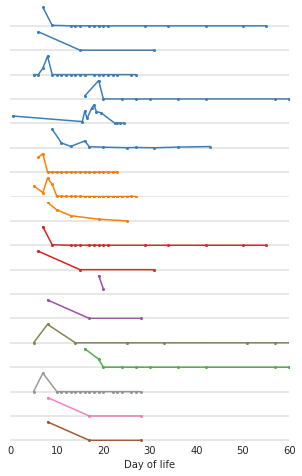

In [66]:
Fdb = Bdb.copy()

# order infants
Fdb['infant'] = pd.Categorical(Fdb['infant'], iorder)
Fdb = Fdb.sort_values('infant')

# order names
Fdb['common_name'] = pd.Categorical(Fdb['common_name'], order)
Fdb = Fdb.sort_values('common_name')

# set up figure
num_plots = (len(Fdb[Fdb['breadth'] > 0.1].drop_duplicates(\
        subset=['common_name', 'infant'])))
fig = plt.figure()
sns.set_style('white')

# make the plots
i = 1
axs = []
for gen, gdb in Fdb.groupby('common_name'):
    for inf, db in gdb.groupby('infant'):
        if len(db[db['breadth'] >= .1]) == 0:
            continue
        db = db[db['DOL'] != 0]
        db.sort_values('DOL', inplace=True)
        
        if len(db) == 0:
            print("ERROR {0}".format(inf))
            continue
            
        if i == 1: # first plot
            ax1 = fig.add_subplot(num_plots,1,i) # nrows, ncols, plot_number, top sparkline)
            ax = ax1
        elif i == (num_plots): # last plot
            axL = fig.add_subplot(num_plots,1,i, sharex=ax1)
            ax = axL
        else:
            ax = fig.add_subplot(num_plots,1,i, sharex=ax1)
        i += 1
        
        ax.plot(db['DOL'], db['relative_abundance'], c=cm[gen], marker='o', markersize=2)
        ax.axhline(0, c='grey', alpha=0.25)
        axs.append(ax)
        
        print("{0} {1} {2:.2f}".format(gen, inf, db['relative_abundance'].max()))
        #print("{2:.1f}%".format(gen, inf, db['pp'].max()))
        #print("{0} {1}".format(db['DOL'].min(), db['DOL'].max()))
        
# remove borders
for axes in axs:
    plt.setp(axes.get_xticklabels(), visible=False)
    plt.setp(axes.get_yticklabels(), visible=False)
    plt.setp(axes.get_xticklines(), visible=False)
    plt.setp(axes.get_yticklines(), visible=False)
    plt.setp(axes.spines.values(), visible=False)
    
# bottom
plt.setp(axL.get_xticklabels(), visible=True)
plt.setp(axL.get_xticklines(), visible=True)
axL.xaxis.tick_bottom()
           
# display
plt.xlim(0,60)
plt.xticks([0,10,20,30,40,50,60], [0,10,20,30,40,50,60])
plt.xlabel('Day of life')
fig.set_size_inches(5, 8)
#plt.savefig(fig_loc + 'sparkline_v1.1.pdf', bbox_inches='tight')
plt.show()

# MDS of NICU room

### Subset to Room samples

In [67]:
Bdb = Gdb.copy()
Bdb = Gdb[Gdb['loc'] == 'R']

Bdb = Bdb[Bdb['genome'].isin(list(Bdb['genome'][Bdb['breadth'] >= .1].unique()))]
Bdb = Bdb[Bdb['breadth'] >= 0.1]

### Compute bray-curtis distances

In [69]:
table = defaultdict(list)
genomes = list(Bdb['genome'].unique())
for samp in Bdb['sample'].unique():
    g2p_1 = Bdb[Bdb['sample'] == samp].set_index('genome')['relative_abundance'].to_dict()
    for samp2 in Bdb['sample'].unique():
        g2p_2 = Bdb[Bdb['sample'] == samp2].set_index('genome')['relative_abundance'].to_dict()
        
        g1 = [g2p_1[x] if x in g2p_1 else 0 for x in genomes]
        g2 = [g2p_2[x] if x in g2p_2 else 0 for x in genomes]
        dist = scipy.spatial.distance.braycurtis(g1, g2)
        
        table['sample1'].append(samp)
        table['sample2'].append(samp2)
        table['distance'].append(dist)
Ddb = pd.DataFrame(table)

### Set up colors and markers

In [70]:
c2r = {}
for room, color in zip(Gdb['infant'].unique(),
    ['#e6194b', '#3cb44b', "#ffe119", "#0082c8", "#f58231", "#911eb4"]):
    c2r[room] = color
s2m = {'1':'o', '2':'^', '3':'s'}

### Re-name

In [78]:
n2n = {'C_parapsilosis_CDC317_current_chromosomes': 'Candida parapsilosis',
       'Nectria haematococca mpVI 77-13-4':'Nectria haematococca', 
       'Malassezia globosa CBS 7966':'Malassezia globosa',
       'Purpureocillium lilacinum':'Purpureocillium lilacinum', 
       'S2_005_001R2_Rhabditida':'Rhabditida S2_005_001R2',
       'S2_005_001R2_Verruconis_gallopava':'Verruconis sp. S2_005_001R2',
       'S2_005_002R2_Diptera':'Diptera S2_005_002R2',
       'S2_009_000R2_Exophiala_mesophila':'Exophiala sp. S2_009_000R2',
       'S2_018_000R1_Malassezia_globosa':'Malassezia sp. S2_018_000R1'}
Bdb['name2'] = Bdb['name'].map(n2n)

### Plot

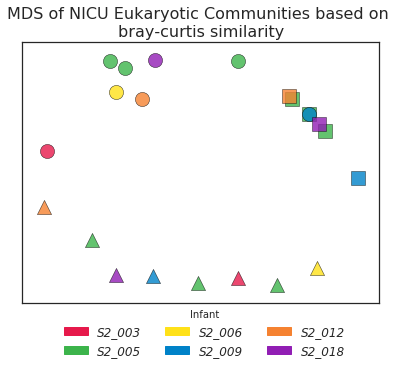

In [79]:
# Get set up
linkage_db = Ddb.pivot("sample1","sample2","distance")
names = list(linkage_db.columns)
mds = sklearn.manifold.MDS(n_components=2, dissimilarity="precomputed", random_state=6)
results = mds.fit(linkage_db)

# Pull coordinates
coords = results.embedding_
sns.set_style('white')
sns.set_context(font_scale=1.5)

# Plot one at a time
for name, x, y in zip(names, coords[:, 0], coords[:, 1]):
    # set color
    colors = [c2r[name[:6]]]
    # set marker
    m = s2m[name[11]]
    
    plt.scatter(
        x, y, marker = m, linestyle = 'None',\
        color=colors, s=200,  edgecolors='black', linewidths=0.5, alpha=0.8)

# Horrible annotation
if False:
    for label, x, y in zip(names, coords[:, 0], coords[:, 1]):
        plt.annotate(
            label,
            xy = (x, y), xytext = (-20, 20),
            textcoords = 'offset points', ha = 'right', va = 'bottom',
            bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
            arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

# Add color legend
legendC = c2r
patches = [mpatches.Patch(color = color, label = label)
            for label, color in zip(sorted(list(legendC.keys())),\
            [c2r[x] for x in sorted(legendC.keys())])]
lgd = plt.legend(patches, sorted(list(legendC.keys())), loc='lower center', \
            prop = {'size': 12, 'style': 'italic'}, title='Infant', ncol=3, bbox_to_anchor=(.51, -0.25))

# Adjust figure properties
axes = plt.gca()
fig = plt.gcf()
fig.set_size_inches(6.4, 4.8)
plt.title('MDS of NICU Eukaryotic Communities based on \nbray-curtis similarity', size=16)
plt.xticks([])
plt.yticks([])

#plt.savefig(fig_loc + 'NICU_MDS_v2' + ".pdf",format="pdf",transparent=True, bbox_inches='tight')
plt.show()

### Make dendrogram of same thing (decided not to really follow up on)

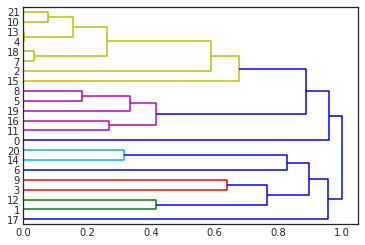

In [80]:
# Prepare linkage
linkage_db = Ddb.pivot("sample1","sample2","distance")
arr =  np.asarray(linkage_db)
arr = scipy.spatial.distance.squareform(arr)
linkage = scipy.cluster.hierarchy.linkage(arr, method='average')

# Plot heirarchical
scipy.cluster.hierarchy.dendrogram(linkage,orientation='right')
plt.show()

### Make bar chart

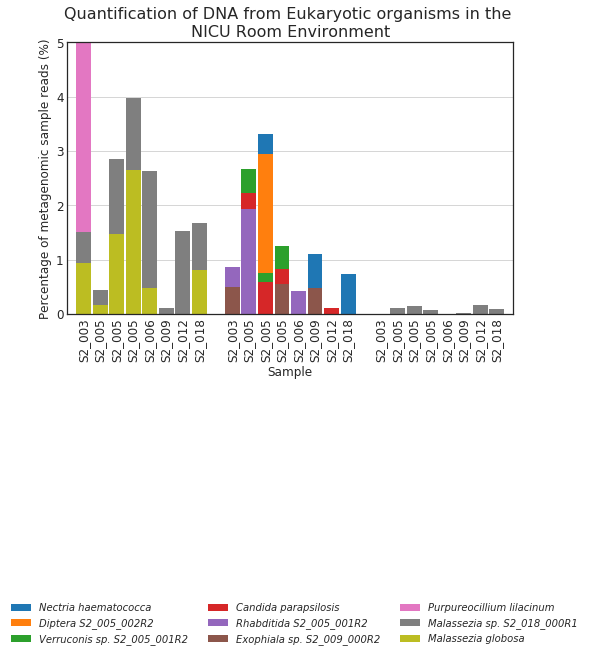

In [82]:
def simple_stacks_v2_custom(data, x, y, hue, palette = False, size = (5, 3), \
                    xlim = False, ylim = False, xtitle='', ytitle='',\
                    width = 0.75, title='', save=False, x2x=None):
    """
    plot stacked bar chart
    
    * v2 = just cleaned up a little with more comments and other minor fixes
    
    palette = hue -> color
    """

    # legend
    plt.legend(loc='best', prop = {'size': 10})

    # order to plot each item based on most abundant first
    items = list(data[hue].unique()) # all hues (genomes)
#     items = [(sum([i for i in data[data[hue] == s][y].values\
#                    if type(i) is float]), s) for s in items] # (sum of values, hue)
#     items = [i[1] for i in sorted(items, reverse = True)] # hues ordered by sum

    # values
    X_labels = list(data[x].unique()) # All x labels
    X = list(range(0, len(X_labels))) # range of x labels

    # count data for plotting
    running = [0 for i in X]
    Iabundance = [] # [hue, [sum(hue) for every x + previous hues], [sum(hue) for every x ]]
    for s in items:
        hdb = data[data[hue] == s] # dataframe with only this hue (s)
        abundance = [] # list of the abundance of values for this hue
        for xi in X_labels:
            a = np.nan_to_num(hdb[hdb[x] == xi][y].values) # all values of this hue + x
            if len(a) == 0:
                abundance.append(0)
            else:
                a = [i for i in a if type(i) is not str] 
                abundance.append(np.nansum(a)) # append all values
                
        running = [i + j for i, j in zip(running, abundance)] # this hue + all previous hues
        Iabundance.append([s, running, abundance])
    
    # plot abundance
    for s, running, abundance in Iabundance[::-1]:
        # s = hue, running = [sum(x) + previous for x in hue]
        if palette == False:
            plt.bar(X, running, \
                             label = s,\
                            width = width, alpha = 1)
        else:
            plt.bar(X, running, \
                             label = s, color = palette[s],\
                            width = width, alpha = 1)
    if x2x != None:
        plt.xticks([xi for xi in X], [x2x[x] if x[-1] != 'X' else '' for x in X_labels], rotation='vertical')
    else:
        plt.xticks([xi for xi in X], [x if x[-1] != 'X' else '' for x in X_labels], rotation='vertical')
    #plt.xticks(X, X_labels, rotation='vertical')

    # legend
    plt.legend(loc='lower center', bbox_to_anchor=(.51, -1.25), \
            prop = {'size': 10, 'style': 'italic'}, ncol=3)
    
#     plt.legend(loc='upper right', bbox_to_anchor=(0.5, 1.05),
#           ncol=3, fancybox=True, shadow=True)

    # ylim
    if ylim != False:
        plt.ylim(0,ylim)
        
    # xlim
    plt.xlim(-1, len(X_labels))

    # title
    plt.title(title)
    plt.xlabel(xtitle)
    plt.ylabel(ytitle)

    # save
    if save != False:
        plt.savefig(str(save) + ".pdf",format="pdf",transparent=True, bbox_inches='tight')

Fdb = Bdb.copy()

# Add blanks
table = defaultdict(list)
for b in ['bl1', 'bl2', "S2_003_000R3", "S2_006_000R3"]:
    table['sample'].append(b)
    table['name2'].append(Fdb['name2'].tolist()[0])
    table['relative_abundance'].append(0)
Fdb = Fdb.append(pd.DataFrame(table))
    
# Re-order
#print('",\\\n"'.join(list(Gdb['sample'].unique())))
order = [\
"S2_003_000R1",\
"S2_005_001R1",\
"S2_005_002R1",\
"S2_005_003R1",\
"S2_006_000R1",\
"S2_009_000R1",\
"S2_012_000R1",\
"S2_018_000R1",\
"bl1",\
"S2_003_000R2",\
"S2_005_001R2",\
"S2_005_002R2",\
"S2_005_003R2",\
"S2_006_000R2",\
"S2_009_000R2",\
"S2_012_000R2",\
"S2_018_000R2",\
"bl2",\
"S2_003_000R3",\
"S2_005_001R3",\
"S2_005_002R3",\
"S2_005_003R3",\
"S2_006_000R3",\
"S2_009_000R3",\
"S2_012_000R3",\
"S2_018_000R3"]
Fdb['sample'] = pd.Categorical(Fdb['sample'], order)
Fdb.sort_values(['sample', 'name2'], inplace=True)
#assert len(Fdb['sample'].unique()) == 26, len(Fdb['sample'].unique())

# set up xlabel translation
#s2s = {'R1':'swabs', 'R2':'sinks', 'R3':'wipes'}
x2x = {x:x[:6] for x in Fdb['sample'].unique()}
x2x['bl1'] = ''
x2x['bl2'] = ''

# Do normal plot
sns.set_style('white')
matplotlib.rcParams.update({'font.size': 12})
simple_stacks_v2_custom(data=Fdb, x='sample', y='relative_abundance', hue='name2', width=0.9, x2x=x2x)

# Adjust
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(8, 5)
plt.ylim(0,5)
plt.gca().yaxis.grid(True)
plt.ylabel('Percentage of metagenomic sample reads (%)')
plt.xlabel("Sample")
plt.title('Quantification of DNA from Eukaryotic organisms in the \nNICU Room Environment', size=16)

#plt.savefig(fig_loc + 'raw_NICU_Quant_v2.1' + ".pdf",format="pdf",transparent=True, bbox_inches='tight')
plt.show()